In [1]:
import scvi
import os
import tempfile
import scanpy as sc
import seaborn as sns
import torch
import pandas as pd
from rich import print
import numpy as np
import matplotlib.pyplot as plt
import skmisc

/home/users/allstaff/moore.z/.conda/envs/scvi-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_float32_matmul_precision('high')

In [3]:
adata = sc.read("/vast/scratch/users/moore.z/pdo_compar/data/intermed/1_seurat_all_anndata.h5ad")
adata.X = adata.layers["counts"]
adata

AnnData object with n_obs × n_vars = 19198 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'bc_wells', 'sample', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'line', 'type', 'numbat_clone', 'numbat_compartment', 'numbat_p', 'S.Score', 'G2M.Score', 'Phase', 'percent_mito', 'RNA_snn_res.0.8', 'seurat_clusters', 'scores.Astro.x', 'scores.Mesenchymal.x', 'scores.Neuronal.x', 'scores.Oligo.x', 'scores.Progenitor.x', 'scores.Unassigned.x', 'labels.x', 'delta.next.x', 'pruned.labels.x', 'pruned.labels.ruiz.x', 'new_label.ruiz.x', 'scores.Astro.y', 'scores.Mesenchymal.y', 'scores.Neuronal.y', 'scores.Oligo.y', 'scores.Progenitor.y', 'scores.Unassigned.y', 'labels.y', 'delta.next.y', 'pruned.labels.y', 'pruned.labels.ruiz.y', 'new_label.ruiz.y', 'individual_normal_clusters', 'numbat_filtered', 'scores.Astro', 'scores.Mesenchymal', 'scores.Neuronal', 'scores.Oligo', 'scores.Progenitor', 'scores.Unassigned', 'labels

In [4]:
from scipy import sparse

sparse_X = sparse.csr_matrix(adata.X)
adata.X = sparse_X

In [9]:
# integration with scVI
scvi.model.SCVI.setup_anndata(
    adata = adata, 
    batch_key = "sample"
)
# create model
scvi_model = scvi.model.SCVI(
    adata = adata,
    n_hidden = 128,
    n_latent = 50,
    dispersion = "gene-batch"
)
scvi.settings.seed = 42
# train model 
scvi_model.train(
    max_epochs = 1000, 
    early_stopping = True,
    accelerator = "gpu"
)

[rank: 0] Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 492/1000:  49%|████▉     | 492/1000 [08:40<08:57,  1.06s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.77e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1828.815. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

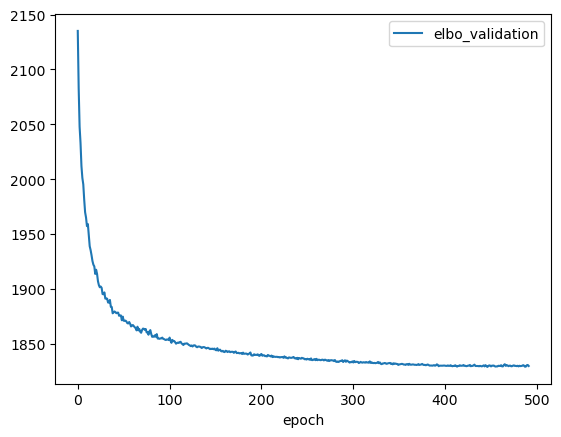

In [10]:
scvi_model.history["elbo_validation"].plot()

In [11]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [12]:
sc.pp.neighbors(
    adata = adata, 
    use_rep = SCVI_LATENT_KEY, 
    n_neighbors = 15,
    n_pcs = 50,
    method = "gauss",
    knn = False
)
sc.tl.leiden(
    adata,
    flavor = "igraph",
    resolution = 1,
    n_iterations = 10
)

In [13]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/home/users/allstaff/moore.z/.conda/envs/scvi-env/lib/python3.12/site-packages/matplotlib/colors.py:1404: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


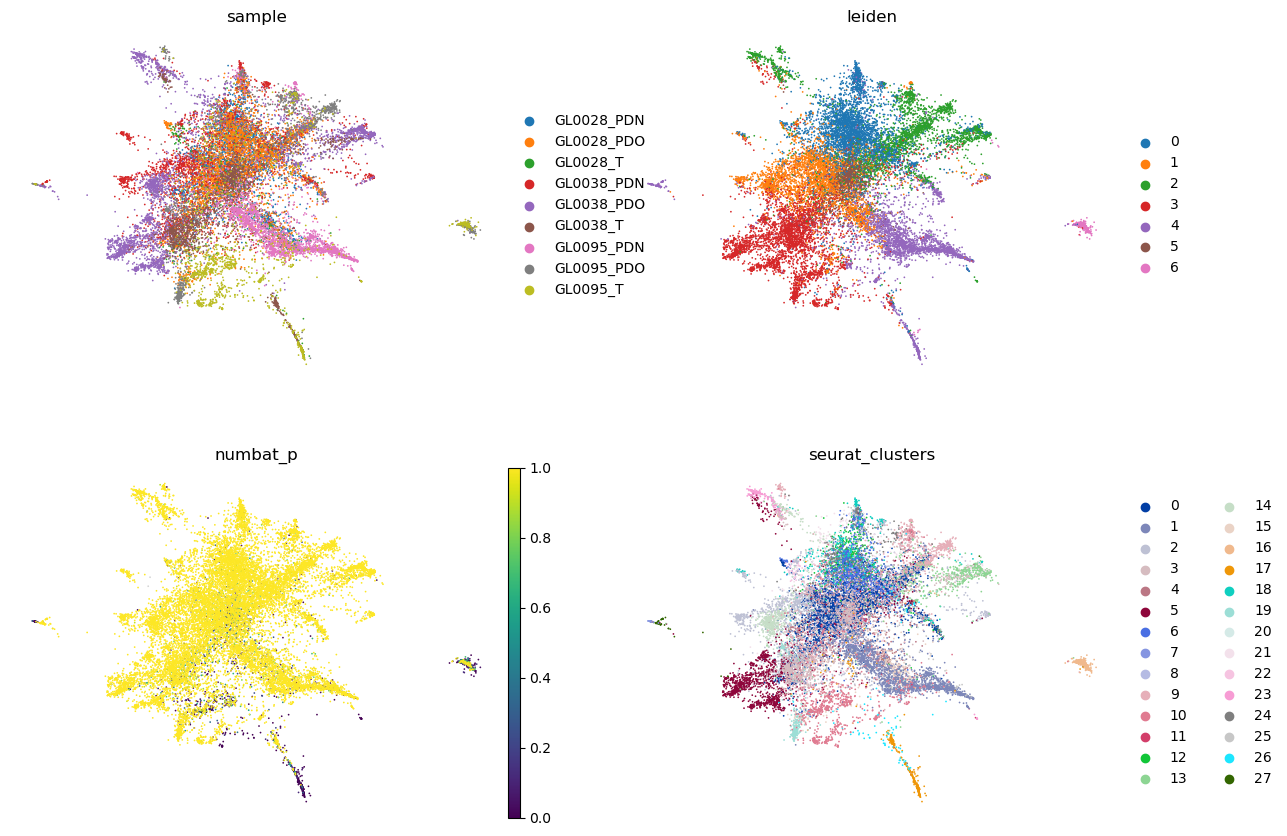

In [14]:
sc.pl.embedding(
    adata = adata,
    basis = SCVI_MDE_KEY,
    color = ["sample", "leiden", "numbat_p", "seurat_clusters"],
    frameon = False,
    ncols = 2,
)

In [15]:
adata.write_h5ad("/vast/scratch/users/moore.z/pdo_compar/data/intermed/snrnaseq/scvi_all_integrated.h5ad")

In [ ]:
change_per_cluster = scvi_model.differential_expression(
    adata = adata, 
    groupby = "leiden", 
    batch_correction = True,
    filter_outlier_cells = False
)

In [ ]:
change_per_cluster
change_per_cluster.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_compar/data/intermed/snrnaseq/5_de_leiden_overall.csv")

In [ ]:
adata.write_h5ad("/vast/scratch/users/moore.z/pdo_compar/data/intermed/snrnaseq/6_overall_scvi.h5ad")

In [ ]:
# import scipy as sp
# con = adata.obsp["connectivities"]
# dist = adata.obsp["distances"]

# con = pd.DataFrame(con)
# dist = pd.DataFrame(dist)

In [ ]:
data_pdo_tis = pd.DataFrame()
for x in list(adata.obs["leiden"].unique()):
    res_pdo_tis = scvi_model.differential_expression(
    adata = adata, 
    groupby = "leiden",
    group1 = x,
    group2 = x,
    batch_correction = True,
    batchid1 = ["GL0095_PDO"],
    batchid2 = ["GL0095_T"]
)
    data_pdo_tis = pd.concat([data_pdo_tis, res_pdo_tis])

data_pdn_tis = pd.DataFrame()
for x in list(adata.obs["leiden"].unique()):
    res_pdn_tis = scvi_model.differential_expression(
    adata = adata, 
    groupby = "leiden",
    group1 = x,
    group2 = x,
    batch_correction = True,
    batchid1 = ["GL0095_PDN"],
    batchid2 = ["GL0095_T"]
)
    data_pdn_tis = pd.concat([data_pdn_tis, res_pdn_tis])

data_pdn_pdo = pd.DataFrame()
for x in list(adata.obs["leiden"].unique()):
    res_pdn_pdo = scvi_model.differential_expression(
    adata = adata, 
    groupby = "leiden",
    group1 = x,
    group2 = x,
    batch_correction = True,
    batchid1 = ["GL0095_PDN"],
    batchid2 = ["GL0095_PDO"]
)
    data_pdn_pdo = pd.concat([data_pdn_pdo, res_pdn_pdo])

In [ ]:
data_pdn_tis.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_PDN_TIS.csv")
data_pdo_tis.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_PDO_TIS.csv")
data_pdn_pdo.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_PDN_PDO.csv")

In [ ]:
norm_matrix = scvi_model.get_normalized_expression(
    adata = adata,
    transform_batch = ["GL0095_PDN", "GL0095_PDO", "GL0095_T"],
    # library_size = "latent"
    library_size = 1
) 

In [ ]:
norm_matrix.transpose().to_csv(path_or_buf="/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_norm.csv")

In [ ]:
#ref_adata.write_h5ad("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/3_scvi/GL0095_post.h5ad")

In [ ]:
latent_dims = adata.obsm["X_scVI"]
latent_dims = pd.DataFrame(latent_dims)
latent_dims.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_latent_dims.csv")
mde_dims = adata.obsm["X_scVI_MDE"]
mde_dims = pd.DataFrame(mde_dims)
mde_dims.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_MDE.csv")

In [ ]:
leiden = adata.obs["leiden"]
leiden = pd.DataFrame(leiden)
leiden.to_csv(path_or_buf = "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0095_leiden.csv")

In [ ]:
reference_adata = sc.read("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/scanvi_couturier/couturier.h5ad")
reference_adata

In [ ]:
reference_adata = reference_adata[:, reference_adata.var_names.intersection(intersection)]
reference_adata

In [ ]:
import scipy 
reference_adata.X = scipy.sparse.csr_matrix(reference_adata.X)

reference_adata.layers["counts"] = reference_adata.X.copy()
reference_adata

In [ ]:
scvi.model.SCVI.setup_anndata(
    reference_adata, 
    batch_key = "Sample", 
    layer = "counts"
)

scvi_reference_model = scvi.model.SCVI(
    adata = reference_adata,
    n_hidden = 128,
    n_latent = 50,
    dispersion = "gene-batch"
)
# train model 
# model.train()
# scvi.settings.dl_num_workers = 11
scvi_reference_model.train(
    max_epochs = 1000, 
    early_stopping = True
)

In [ ]:
scvi_reference_model.history["elbo_validation"].plot()

In [ ]:
SCVI_LATENT_KEY = "X_scVI"
reference_adata.obsm[SCVI_LATENT_KEY] = scvi_reference_model.get_latent_representation()

In [ ]:
sc.pp.neighbors(
    adata = reference_adata, 
    use_rep = SCVI_LATENT_KEY, 
    n_neighbors = 15,
    n_pcs = 50
)
sc.tl.leiden(
    reference_adata,
    flavor = "igraph",
    resolution = 1,
    n_iterations = 10
)

In [ ]:
SCVI_MDE_KEY = "X_scVI_MDE"
reference_adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(reference_adata.obsm[SCVI_LATENT_KEY])

In [ ]:
sc.pl.embedding(
    adata = reference_adata,
    basis = SCVI_MDE_KEY,
    color = ["sample", "leiden"],
    # legend_loc = "on data",
    frameon = False,
    ncols = 2,
)